In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
from PIL import Image
from dcp import *
import matplotlib.pyplot as plt


## old

In [151]:
im0 = Image.open("./data/tinySOTS/hazy/0001_0.8_0.2.jpg")
im = np.asarray(im0, dtype=np.float64)/255

In [3]:
tmp = plt.imread("./data/tinySOTS/hazy/0001_0.8_0.2.jpg")

In [5]:
tmp = plt.imread("./data/tinySOTS/gt/0001.png")

In [6]:
tmp.max()

1.0

In [152]:
dc = get_dark_channel(im, patch_size=(15,15))
A = get_atmos_light(im, dc, top_ratio=1e-3)
tilde_t = get_tilde_t(im, A)

In [142]:
t1 = soft_matting(im, tilde_t)

In [153]:
t2 = guided_filter(im, tilde_t)

In [154]:
J1 = get_J(im, A=A, t=t1)
J2 = get_J(im, A=A, t=t2)

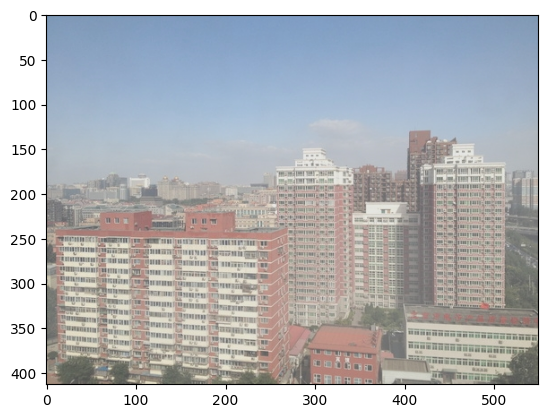

In [155]:
plt.imshow(im)

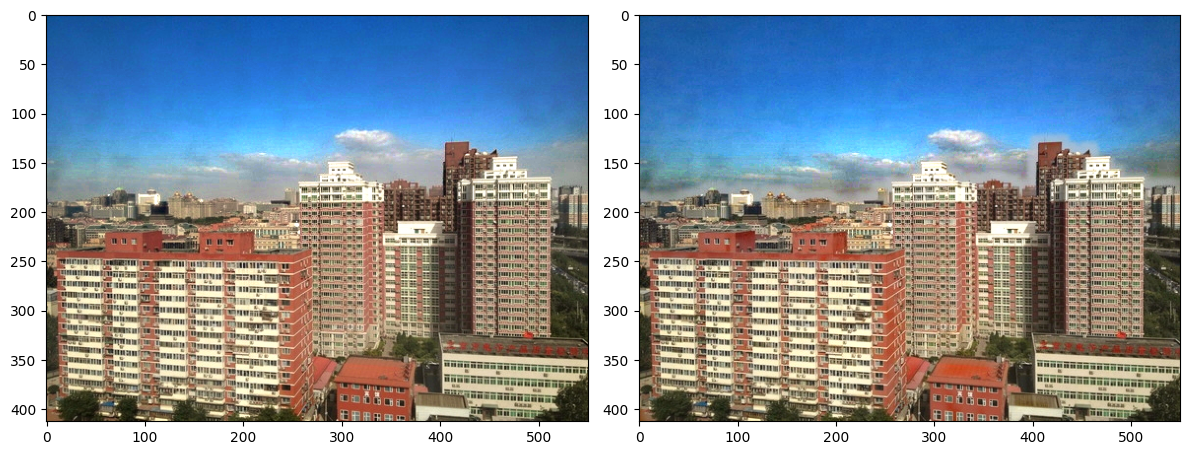

In [156]:
plt.figure(figsize=(12, 5), tight_layout=True)
plt.subplot(1, 2, 1)
plt.imshow(J1)

plt.subplot(1, 2, 2)
plt.imshow(J2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '$J$')

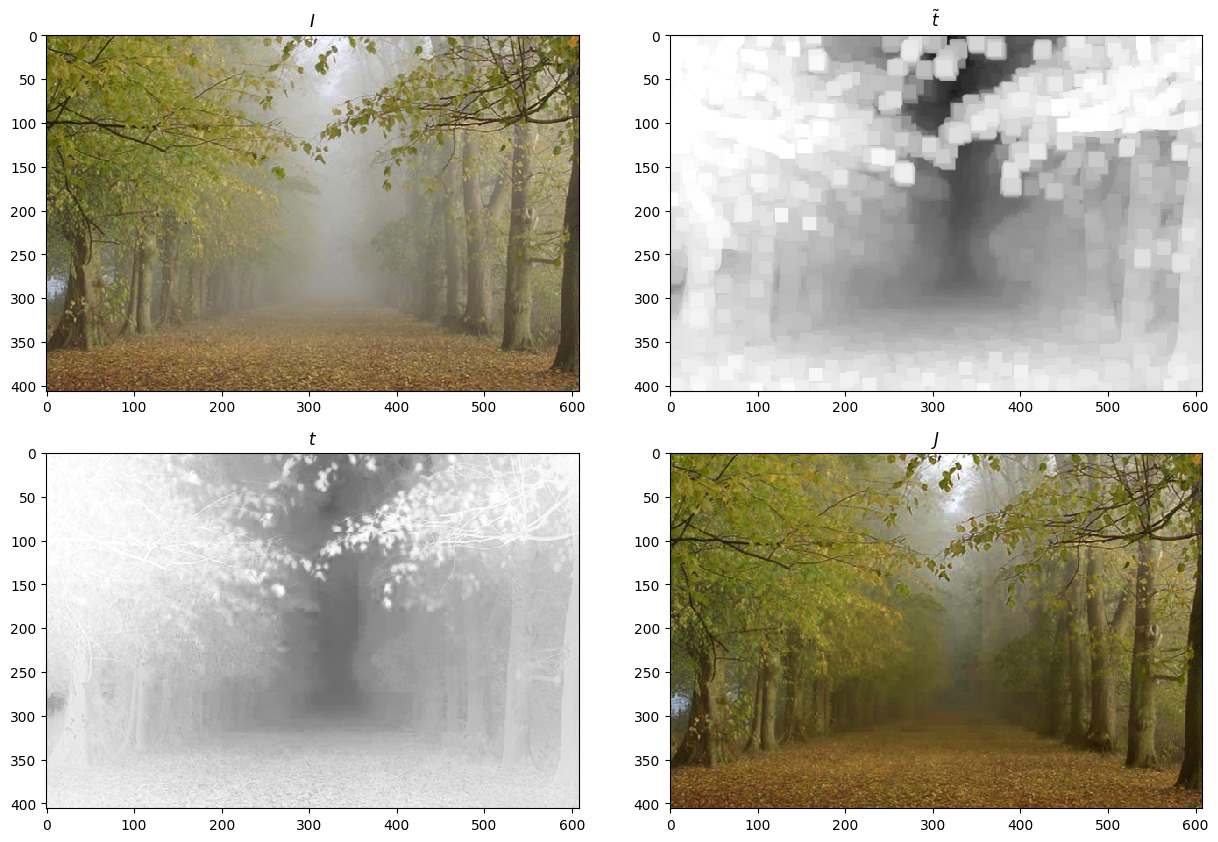

In [9]:
h, w = J.shape[:2]
fig,axs = plt.subplots(
    2, 2,  figsize=(w*2.1/100, h*2.1/100),
    tight_layout=True,
)
opt_f = {
"cmap": "gray",
"vmin": 0,
"vmax" : 1,
"interpolation": 'none'
}
axs[0][0].imshow(im, interpolation='none')
axs[0][0].set_title("$I$")
axs[0][1].imshow(tilde_t, **opt_f)
axs[0][1].set_title("$\\tilde{t}$")

axs[1][0].imshow(t, **opt_f)
axs[1][0].set_title("$t$")

axs[1][1].imshow(J, interpolation='none')
axs[1][1].set_title("$J$")

In [125]:
D = get_depth(t1)

In [128]:
D.max(), D.min()

(2.5819642613527054, -0.10339074054775753)

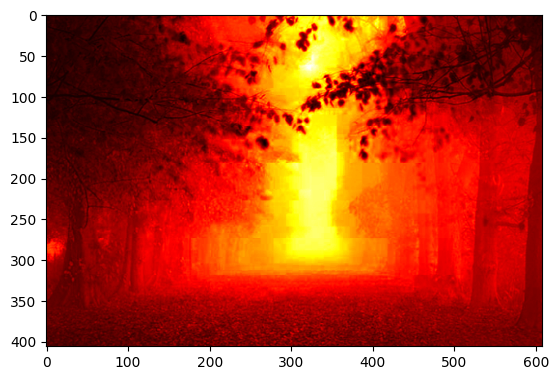

In [129]:
plt.imshow(D, cmap="hot")

## new

In [43]:
from TinySOTS import TinySOTS
from dcp import *
import os
import matplotlib.pyplot as plt

In [34]:
ds = TinySOTS(root="./data/tinySOTS/")

In [45]:
output_dir = "./output/"

In [49]:
opt_byte = {
"cmap": "gray",
"vmin": 0,
"vmax" : 1,
}

opt_rgb = {
"vmin": 0,
"vmax" : 1,
}

In [89]:
import time

In [ ]:
J2 = get_J(hazy, A=A, t=t2)

In [90]:
for i in range(len(ds)):
    gt, hazy = ds[i]
    pre = ds.index[i]
    
    dc = get_dark_channel(hazy, patch_size=(15,15))
    mask = get_mask(dc, top_ratio=1e-3)
    A = get_atmos_light(hazy, dc, top_ratio=1e-3)
    tilde_t = get_tilde_t(hazy, A)

    t1 = time.time()
    t3 = guided_filter(hazy, tilde_t)
    t2 = time.time()
    print(t2 - t1)
    break

    # plt.imsave(os.path.join(output_dir, pre+"_gt.png"), gt, **opt_rgb)
    # plt.imsave(os.path.join(output_dir, pre+"_tilde_t.png"), tilde_t, **opt_byte)
    # plt.imsave(os.path.join(output_dir, pre+"_t1.png"), t1, **opt_byte)
    # plt.imsave(os.path.join(output_dir, pre+"_t2.png"), t2, **opt_byte)
    # plt.imsave(os.path.join(output_dir, pre+"_J1.png"), J1, **opt_rgb)
    # plt.imsave(os.path.join(output_dir, pre+"_J2.png"), J2, **opt_rgb)
    # plt.imsave(os.path.join(output_dir, pre+"_D.png"), D, cmap="hot")
    # plt.imsave(os.path.join(output_dir, pre+"_I.png"), hazy, **opt_rgb)
    

0.10099220275878906


In [91]:
hazy.shape

(413, 550, 3)

In [ ]:
ds[0].hazy.shape

(413, 550, 3)

In [53]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    psnr = 10 * np.log10(1 / mse) 
    return psnr 

In [67]:
from skimage.metrics import structural_similarity as ssim

In [74]:
def SSIM(A, B):
    ssim_r = ssim(A[:, :, 0], B[:, :, 0], data_range=1.0)
    ssim_g = ssim(A[:, :, 1], B[:, :, 1], data_range=1.0)
    ssim_b = ssim(A[:, :, 2], B[:, :, 2], data_range=1.0)
    return  (ssim_r + ssim_g + ssim_b) / 3


In [78]:
p1 = {}
p2 = {}
s1 = {}
s2 = {}

for i in range(len(ds)):
    pre = ds.index[i]
    gt, hazy = ds[i]
    J1 = plt.imread(os.path.join(output_dir, pre+"_J1.png"))[...,:3]
    if J1.dtype == np.uint8:
        J1 = J1 / 255
    J2 = plt.imread(os.path.join(output_dir, pre+"_J2.png"))[...,:3]
    if J2.dtype == np.uint8:
        J2 = J2 / 255

    p1[pre] = PSNR(gt, J1)
    p2[pre] = PSNR(gt, J2)

    s1[pre] = SSIM(gt, J1)
    s2[pre] = SSIM(gt, J2)
    
    

In [79]:
p1

{'0001': 20.157646558434088,
 '0002': 14.804358139846874,
 '0003': 17.71780438515028,
 '0004': 13.38927987974049,
 '0006': 14.442076271773248,
 '0007': 16.751558790266404,
 '0009': 18.464537002206054,
 '0010': 20.963716250764133,
 '0011': 19.48202228770128,
 '0014': 14.86185976579123}

In [85]:
sum(p1.values()) / len(p1)

17.10348593316741

In [86]:
sum(p2.values()) / len(p2)

16.16805255795996

In [87]:
sum(s1.values()) / len(s1)

0.8551243950728041

In [88]:
sum(s2.values()) / len(s2)

0.8126546281804966